## Modelo Pronóstico Oceanic Niño Index (ONI) - Pantaleon Sugar Holdings


**El Niño (La Niña)** es un fenómeno en el Océano Pacífico Ecuatorial caracterizado por una media móvil consecutiva trimestral de anomalías en la temperatura superficial del océano (Sea Surface Temperature o SST) en la *región Niño 3.4* que está por arriba (o por debajo) del umbral de +0.5°C (-0.5°C). A éste estándar de medición se le conoce como el **Índice Océanico del Niño** (Oceanic Niño Index ONI).

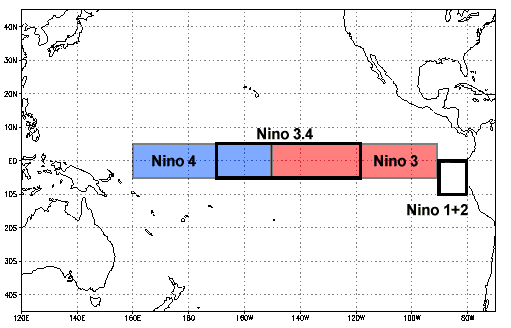


El ONI es la media móvil trimestral de las anomalías (diferencias respecto a la media) en la superficie de la región centro-oriental tropical del océano Pacífico, cercana a la línea internacional del cambio de fecha.

*   https://ggweather.com/enso/oni.htm
*   https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

El ONI es importante para categorizar los efectos NIÑO o NIÑA en una escala DÉBIL, MODERADA, FUERTE y MUY FUERTE.
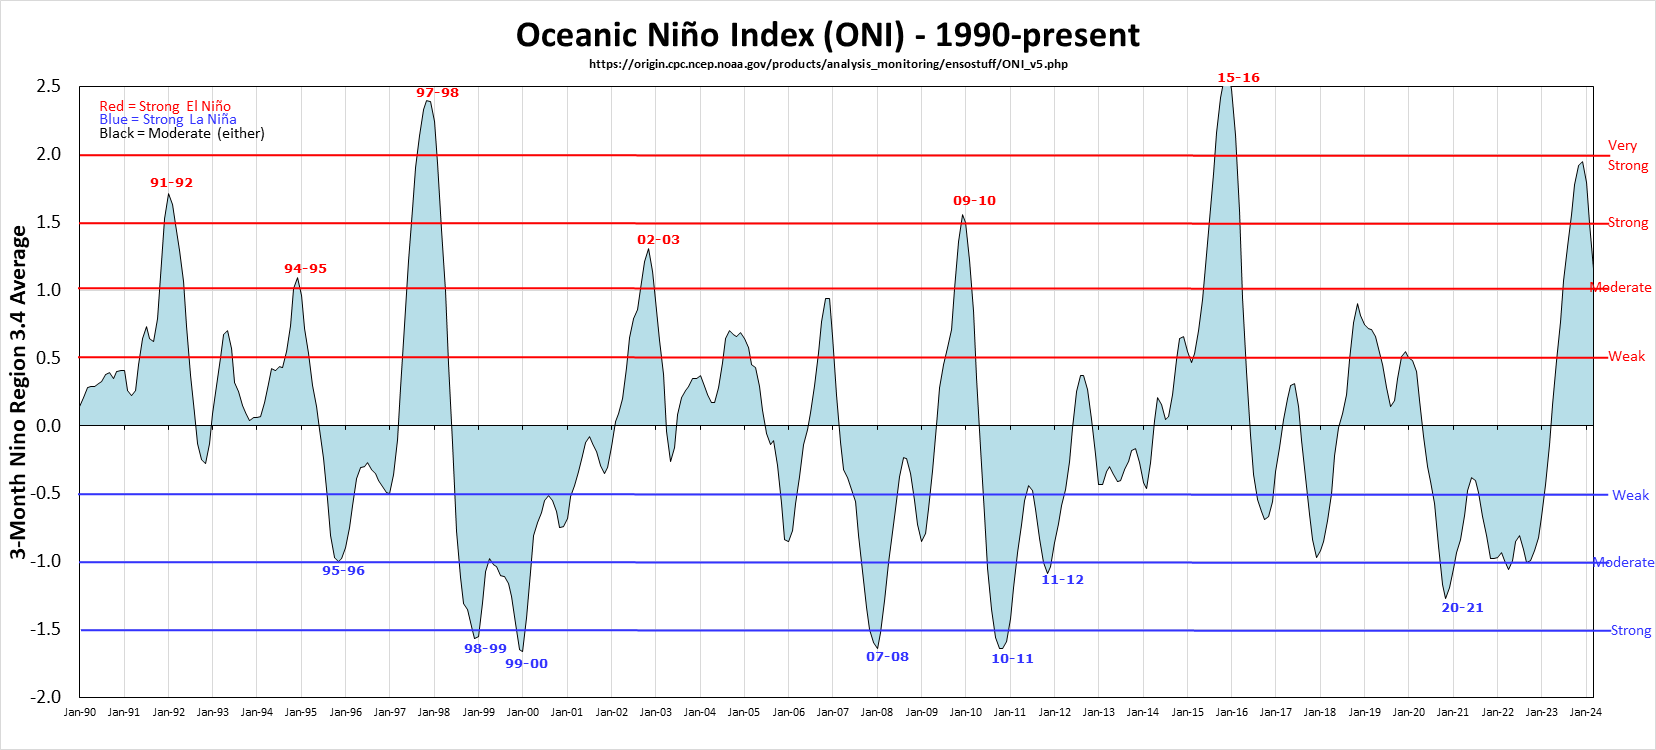
El siguiente trabajo de modelado utiliza una Red Neuronal Recurrente para Series de Tiempo, que permite pronosticar futuros valores del ONI por mes. Este modelamiento se realiza sobre los datos registrados del ONI desde el año 1950 por el National Weather Service del Centro de Predicción Climática (CPC) de los Estados Unidos.

### Southern Oscillation Index (SOI)

El **Southern Oscillation Index (SOI)** es un índice estandarizado basado en las diferencias de presión observadas entre Tahiti y Darwin, Australia medidas al nivel del mar.
El SOI es una medición de fluctuaciones a gran escala de la presión del aire ocurrenido entre el Pacífico tropical occidental y oriental (i.e., el estado de la Oscilación Sureña) durante episodios de El Niño y La Niña. En general, las series de tiempo suavizadas del SOI corresponden muy bien con cambios en las temperaturas océanicas a través del Pacífico tropical oriental. La fase negativa del SOI representa presión del aire por debajo de lo normal en Tahiti y presión del aire sobre lo normal en Darwin. Períodos prolongados de valores SOI negativos (positivos) coinciden con aguas anormalmente calientes (frías) a lo largo del Pacífico oriental tropical que son típicas de episodios de El Niño (La Niña).

La metodología para calcular el SOI y mayor información puede ser encontrada en la página del Climate Prediction Center SOI:

https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml

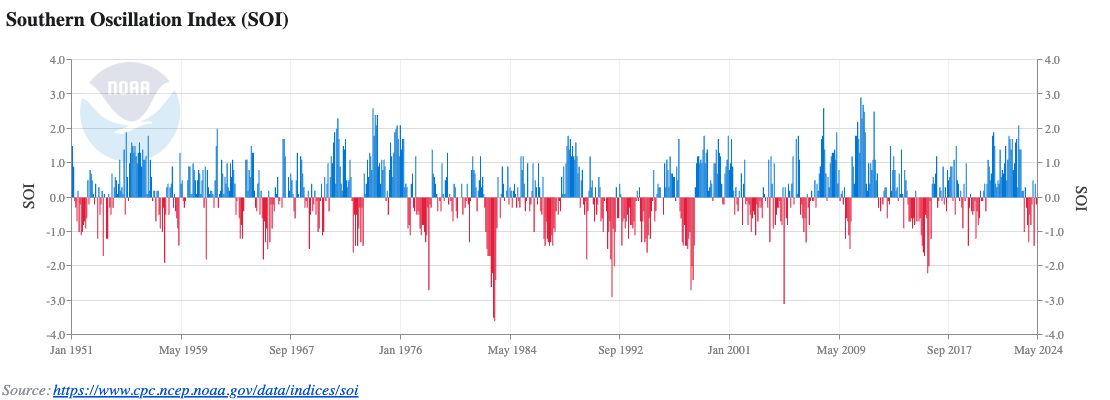


Se presenta un modelo de Deep Learning para el pronóstico del valor de Índice Oceánico de El Niño, que representa el índice que traza el patrón climático de la zona océanica ENSO basado en dos series de tiempo:
- Serie de Tiempo del ONI.
- Serie de Tiempo del SOI.

In [1]:
# DS Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

# Deep Learning Framework
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.saving import load_model

#### Dataset Oceanic Niño Index
- https://www.ncei.noaa.gov/access/monitoring/enso/sst
- https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

In [2]:
# .csv de Anomialias ONI
oni_df = pd.read_csv("ONI_2024.csv")
oni_df.drop(oni_df.head(12).index,inplace=True) # drop first n rows
oni_df['Date'] = oni_df['YR'].astype(str)+'-'+(oni_df.index%12 + 1).astype(str)
oni_df.drop(['YR','SEAS','TOTAL'], axis=1, inplace=True)
oni_df.rename(columns = {'ANOM':'ONI'}, inplace = True)
oni_df

,ONI,Date
12,-0.82,1951-1
13,-0.54,1951-2
14,-0.17,1951-3
15,0.18,1951-4
16,0.36,1951-5
...,...,...
886,1.92,2023-11
887,1.95,2023-12
888,1.79,2024-1
889,1.49,2024-2


In [3]:
ONI = oni_df.ONI.values.reshape(-1, 1)
ONI.shape

(879, 1)

In [4]:
# .csv de Anomialias ONI
soi_df = pd.read_csv("SOI_2024.csv")
years = soi_df['YEAR']
soi_df.drop('YEAR',axis=1,inplace=True)
rows = []
soi = []

numeric_year = 0
for year in years:
    numeric_month = 1
    for month in soi_df:
        rows.append(str(year)+"-"+str(numeric_month))
        soi.append(soi_df.iloc[numeric_year,numeric_month-1])
        numeric_month+=1
    numeric_year+=1
dict ={'SOI':soi,'Date':rows}
soi_df = pd.DataFrame(dict)
soi_df.drop(soi_df.tail(9).index,inplace=True) # drop last n rows
soi_df

,SOI,Date
0,1.5,1951-1
1,0.9,1951-2
2,-0.1,1951-3
3,-0.3,1951-4
4,-0.7,1951-5
...,...,...
874,-0.8,2023-11
875,-0.2,2023-12
876,0.5,2024-1
877,-1.4,2024-2


In [5]:
SOI = soi_df.SOI.values.reshape(-1, 1)
SOI.shape

(879, 1)

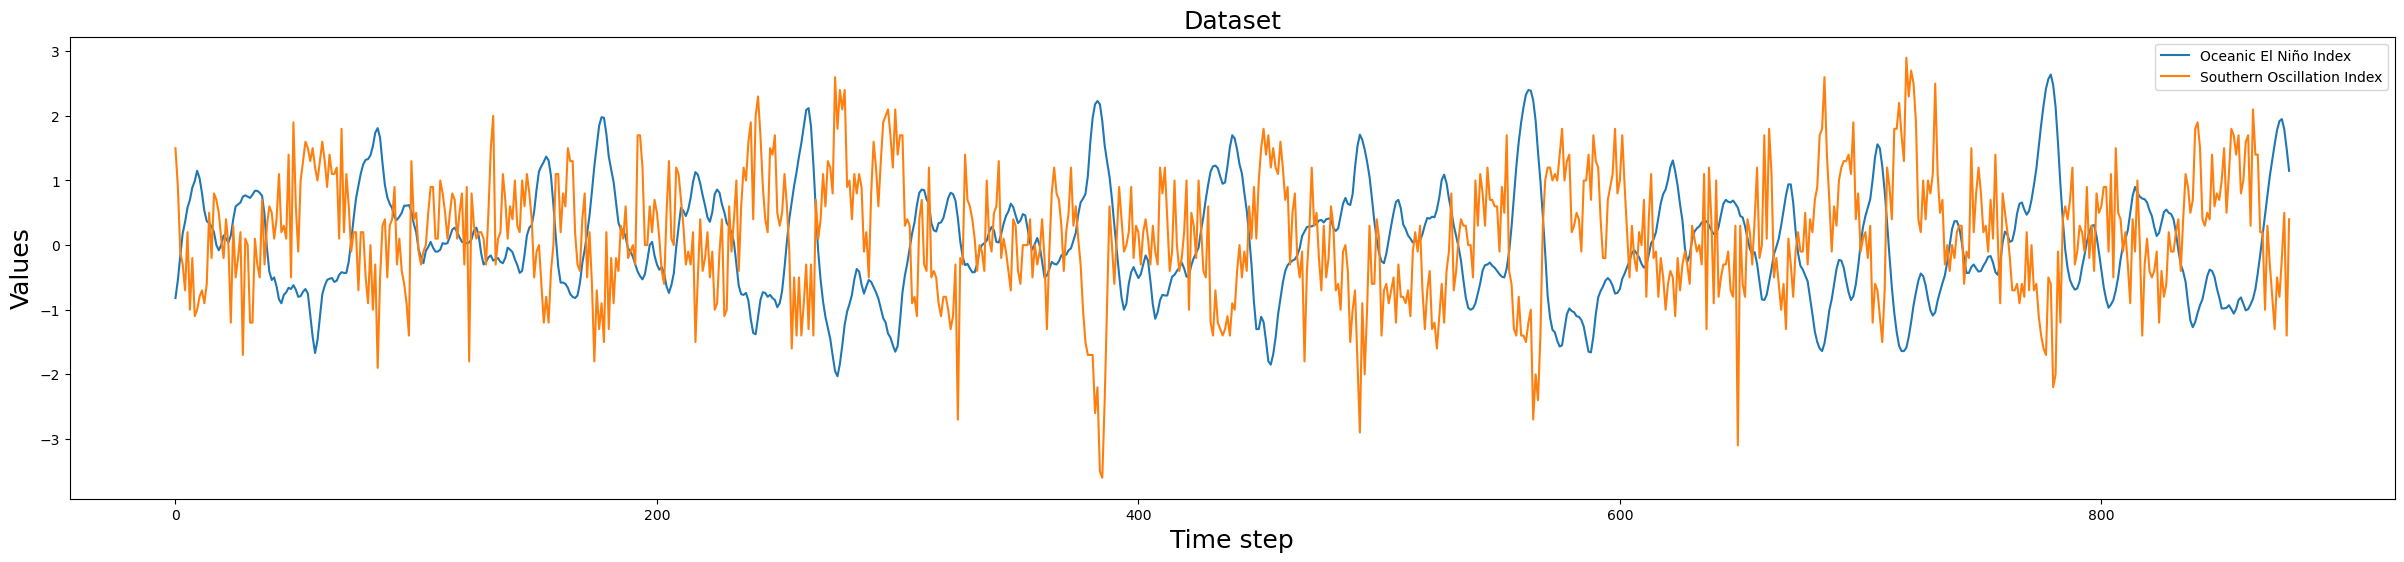

In [6]:
plt.figure(figsize=(30, 6))
plt.plot(ONI , label='Oceanic El Niño Index')
plt.plot(SOI , label='Southern Oscillation Index')
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

#### Evaluation Functions

In [7]:
def plot_train_metrics(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [8]:
def plot_predictions(y, predictions):
  predictions = predictions.flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  plt.title('Predictions vrs. Actuals') 
  plt.ylabel('ONI')
  plt.xlabel('month')
  plt.legend(['Predictions', 'Actuals'], loc='upper left')
  return df, mse(predictions, y)

#### Scaling Transform
Se utiliza una transformación tipo MAX-MIN para evitar desvanecimiento de gradientes.



In [9]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(ONI)
x_2_scaled = scaler.fit_transform(SOI)
y_scaled = scaler.fit_transform(ONI)

# horizontally stack columns
dataset_stacked = np.hstack((x_1_scaled, x_2_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape) 

dataset_stacked.shape (879, 3)


### Modelo de Recurrencia Multiple-Months-Ahead Multivariado

Se define la estructura de datos para utilizar en los modelos de recurrencia.

**Multiple-Month-Ahead** es una generalización del modelo One-Month-Ahead que utiliza una Red Neuronal Recurrente (LSTM, GRU o CNN) en la que valores anteriores de varias series de tiempo correlacionadas con la variable objetivo (determinados por la longitud del horizonte lookback) se utilizan para pronosticar varios valores en el futuro (determinados por la longitud del horizonte forecast). En el ejemplo, se muestra la generalización del modelo para un *lookback* y un *forecast* determinado:

$X1_{Month_{n lookback}} = \{ONI_{Month_1},ONI_{Month_2},ONI_{Month_3}, ... , ONI_{Month_{n lookback - 1}}, ONI_{Month_{n lookback}}\}$

$X2_{Month_{n lookback}} = \{SOI_{Month_1},SOI_{Month_2},SOI_{Month_3}, ... , SOI_{Month_{n lookback - 1}}, SOI_{Month_{n lookback}}\}$ 

para pronosticar 

$y_{Month_{n forecast}}=\{ONI_{Month_{n lookback}}, ONI_{Month_{n lookback + 1}}, ... , ONI_{Month_{n forecast - 1}}, ONI_{Month_{n forecast}} \}$

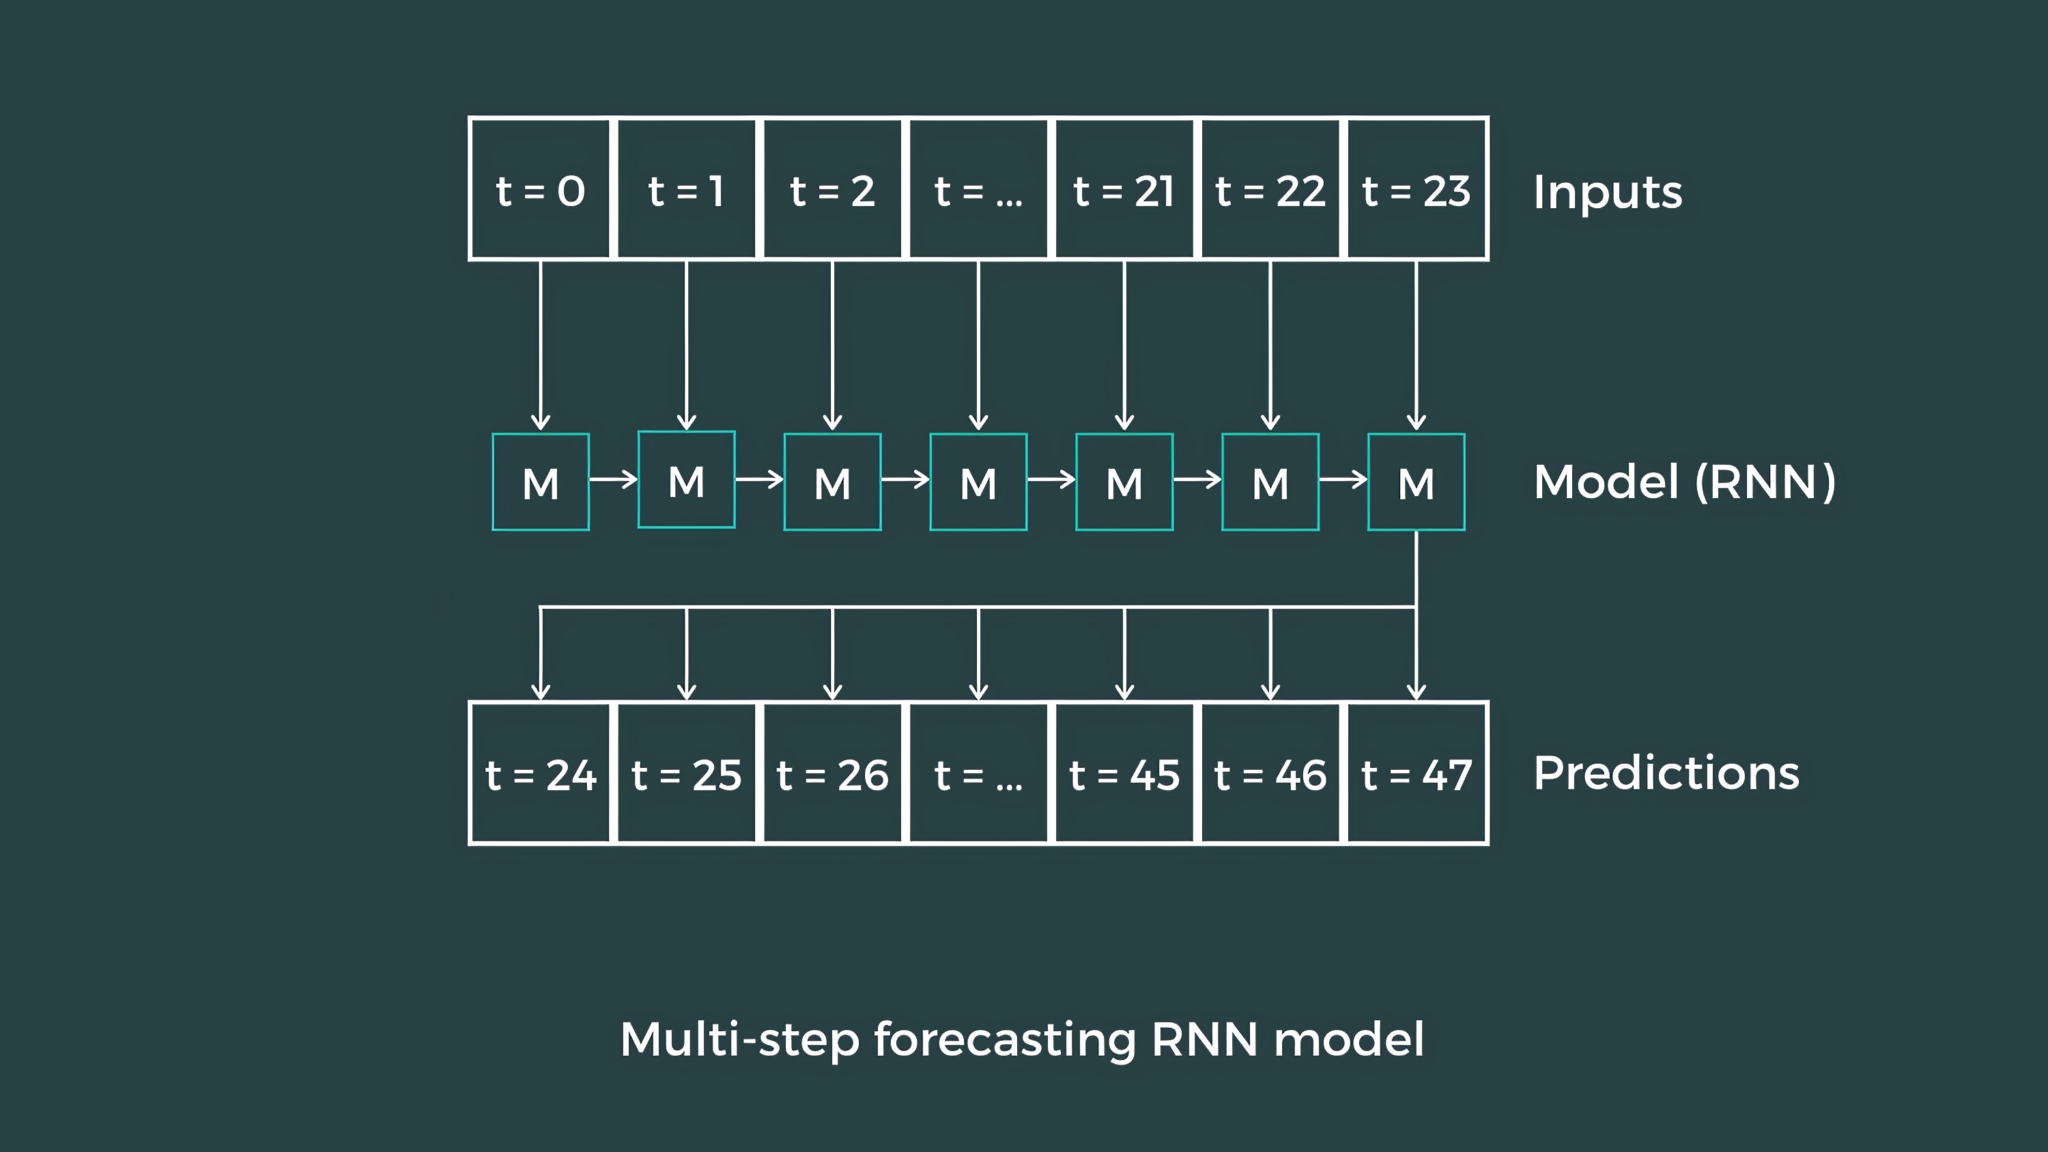

In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
# choose a number of time steps #change this accordingly
n_lookback, n_forecast = 60 , 30 

# covert into input/output
X, y = split_sequences(dataset_stacked, n_lookback, n_forecast)

print ("X.shape" , X.shape) 
print ("y.shape" , y.shape) 

X.shape (791, 60, 2)
y.shape (791, 30)


In [12]:
# Train - Test Split
split = 0.7

index = round(split*X.shape[0])
train_X , train_y = X[:index, :] , y[:index, :]
test_X , test_y = X[index:, :] , y[index:, :]

n_features = train_X.shape[2]

In [13]:
print ("train_X.shape" , train_X.shape) 
print ("train_y.shape" , train_y.shape) 
print ("test_X.shape" , test_X.shape) 
print ("test_y.shape" , test_y.shape) 
print ("n_features" , n_features)

train_X.shape (554, 60, 2)
train_y.shape (554, 30)
test_X.shape (237, 60, 2)
test_y.shape (237, 30)
n_features 2


### LSTM
https://en.wikipedia.org/wiki/Long_short-term_memory

In [14]:
model1 = Sequential()
model1.add(InputLayer((n_lookback, n_features)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(n_forecast, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,942 (70.09 KB)

 Trainable params: 17,942 (70.09 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
cp1 = ModelCheckpoint('oni_model_LSTM_MS/checkpoint.model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [16]:
# Fit network
#history = model.fit(train_X , train_y , epochs=60 , steps_per_epoch=25 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)

history = model1.fit(train_X, train_y,epochs=50, validation_data=(test_X, test_y), shuffle = False, callbacks=[cp1])

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2228 - root_mean_squared_error: 0.4713 - val_loss: 0.1572 - val_root_mean_squared_error: 0.4015
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1817 - root_mean_squared_error: 0.4258 - val_loss: 0.1316 - val_root_mean_squared_error: 0.3675
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1496 - root_mean_squared_error: 0.3863 - val_loss: 0.1070 - val_root_mean_squared_error: 0.3312
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1198 - root_mean_squared_error: 0.3459 - val_loss: 0.0853 - val_root_mean_squared_error: 0.2954
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0945 - root_mean_squared_error: 0.3072 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2627
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0741 - root_mean_squared_error: 0.2721 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2362
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

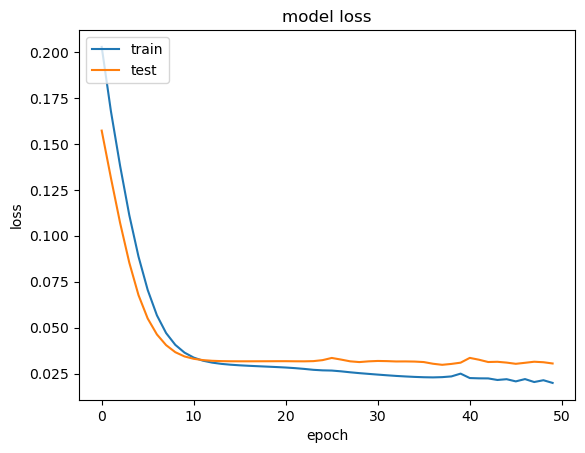

In [17]:
plot_train_metrics(history)

In [18]:
model1 = load_model('oni_model_LSTM_MS/checkpoint.model.keras')

In [19]:
x1_test_scaled = test_X[:,-1,0]
x1_test_scaled = x1_test_scaled.reshape((len(x1_test_scaled), 1))
x2_test_scaled = test_X[:,-1,1]
x2_test_scaled = x2_test_scaled.reshape((len(x2_test_scaled), 1))
y_test = test_y[:,0]
y_test = y_test.reshape((len(y_test), 1))

print(x1_test_scaled.shape)
print(x2_test_scaled.shape)
print(y_test.shape)

(237, 1)
(237, 1)
(237, 1)


In [20]:
def prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last):
    
    #prepare test data X
    dataset_test = np.hstack((x1_test_scaled, x2_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0] , dataset_test_X.shape[1])
    print(test_X_new.shape)

    #prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)

    # predictions
    y_pred = model1.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_forecast,1)
    y_pred_inv = y_pred_inv[:,0]
    
    return y_pred_inv , dataset_test_y , past_data

In [21]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

In [22]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = np.mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

(1, 60, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test Data from 0 to 60
Mean Absolute Error: 0.10
Root Mean Square Error: 0.13


(1, 60, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Data from 60 to 120
Mean Absolute Error: 0.05
Root Mean Square Error: 0.07


(1, 60, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test Data from 120 to 180
Mean Absolute Error: 0.12
Root Mean Square Error: 0.14




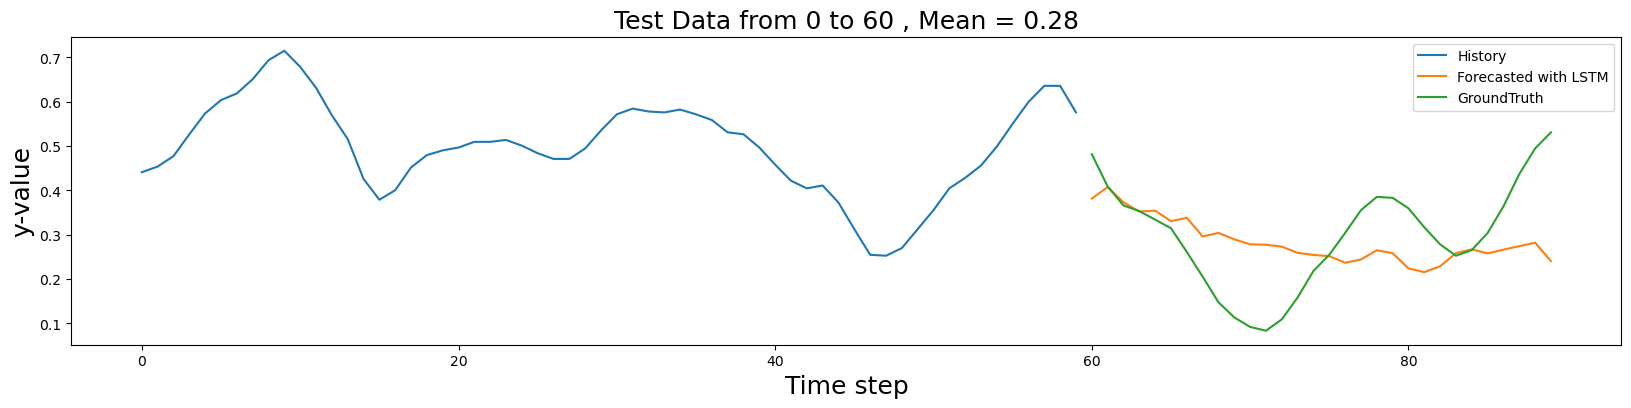

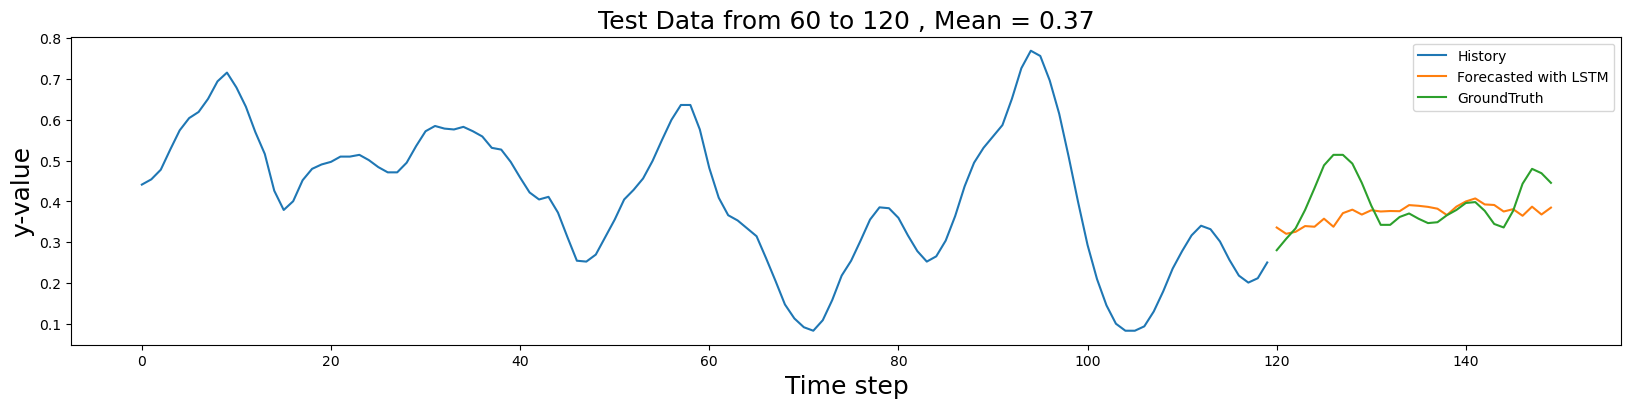

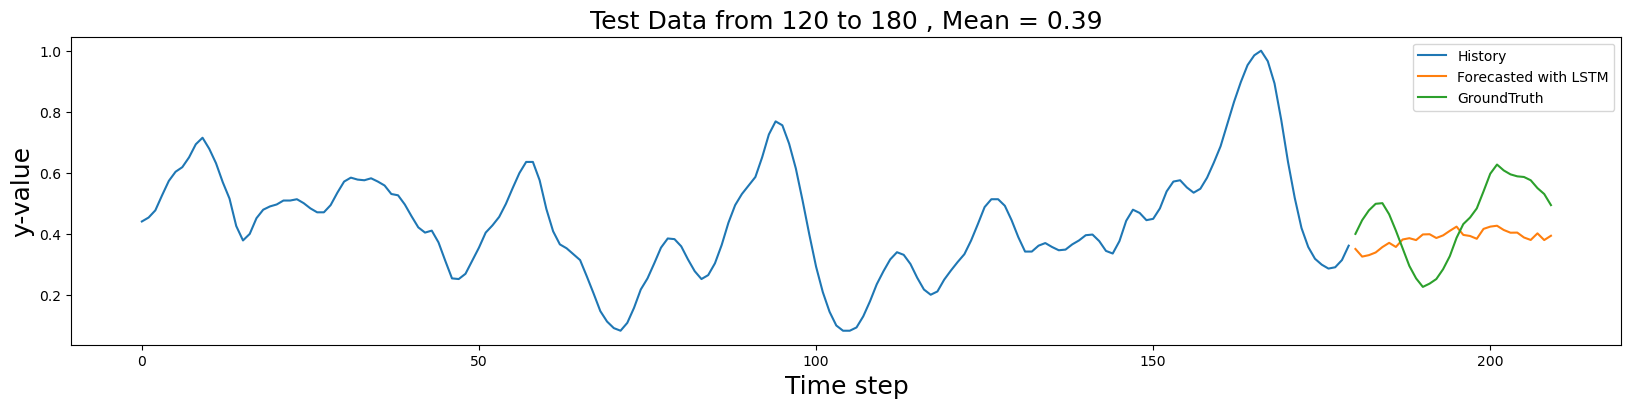

In [23]:
for i in range(0,180,60):
    start = i
    end = start + n_lookback 
    last = end + n_forecast 
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , y_test , start , end , last) 
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end) 
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end) 

### Generate Predictions for El Niño

In [24]:
# Future
test_X_new = test_X[:n_lookback,-1,:]
test_X_new = test_X_new.reshape(1, test_X_new.shape[0] , test_X_new.shape[1])
y_pred = model1.predict(test_X_new)
y_pred = scaler.inverse_transform(y_pred)
predictions = y_pred[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Text(0, 0.5, 'ONI')

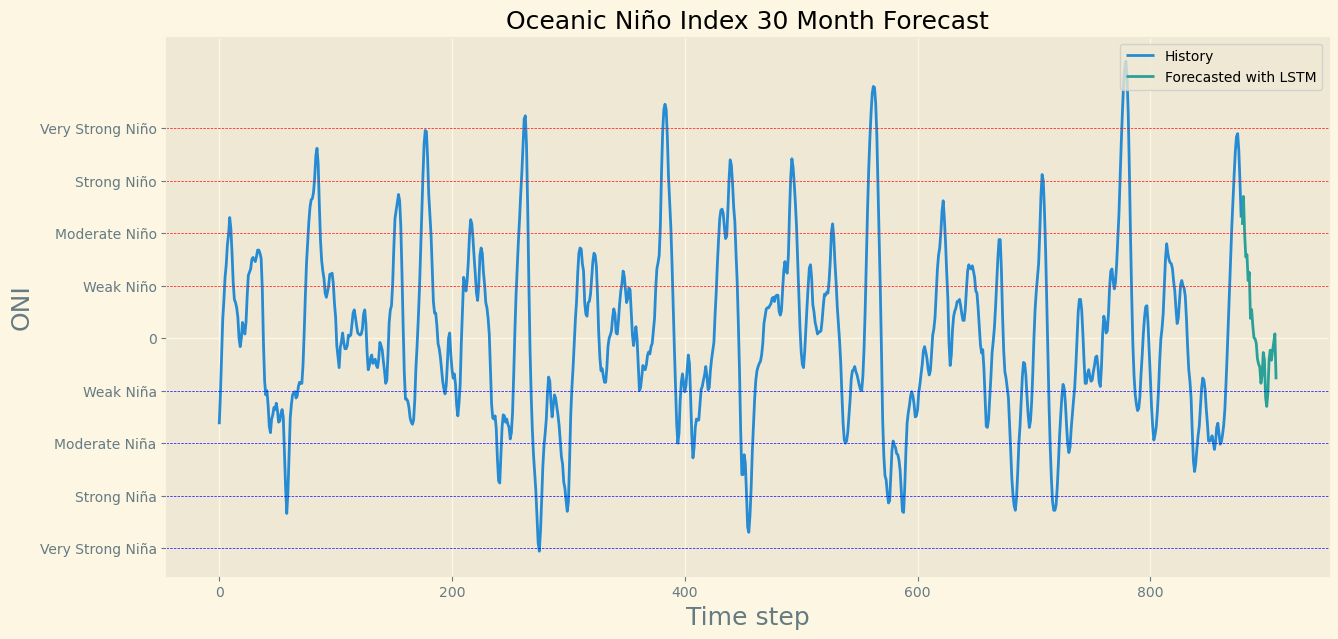

In [25]:

range_history = len(ONI)
range_future = list(range(range_history, range_history + len(predictions)))

plt.style.use("Solarize_Light2")
plt.figure(figsize=(15,7))
plt.plot(np.arange(range_history), ONI, label='History')
plt.plot(range_future, y_pred[0],label='Forecasted with LSTM')

plt.axhline(2.0,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(1.5,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(1.0,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(0.5,color='red',linestyle='--',linewidth = 0.5)
plt.axhline(-0.5,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-1.0,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-1.5,color='blue',linestyle='--',linewidth = 0.5)
plt.axhline(-2.0,color='blue',linestyle='--',linewidth = 0.5)

plt.yticks([2.0, 1.5, 1.0, 0.5, 0, -2.0, -1.5, -1.0, -0.5], ['Very Strong Niño', 'Strong Niño', 'Moderate Niño', 'Weak Niño','0','Very Strong Niña', 'Strong Niña', 'Moderate Niña', 'Weak Niña'])

plt.legend(loc='upper right')
plt.title("Oceanic Niño Index {} Month Forecast".format(n_forecast) ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('ONI' , fontsize=18)


In [26]:
from matplotlib import style 
  
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
